In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , accuracy_score ,classification_report
import joblib

In [2]:
# feature_vector_df = pd.read_csv('../../data/feature_vector_data.csv')
X_labeled , Y_labeled = joblib.load('../../data/feature_imdb.joblib')
# X_labeled = np.random.rand(1000, 10)  # Example features
# Y_labeled = np.random.choice([0, 1], 1000)

In [3]:
print(type(X_labeled), type(Y_labeled))
print(X_labeled.shape, Y_labeled.shape)

<class 'scipy.sparse._csr.csr_matrix'> <class 'pandas.core.series.Series'>
(50000, 5000) (50000,)


In [4]:
splits = [0.8, 0.7, 0.6, 0.5]
for split in splits:
    # Step 1: Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_labeled, Y_labeled, test_size=1-split,stratify= Y_labeled, random_state=42)

    # Save the split data
    joblib.dump((X_train, X_test, y_train, y_test), f'../../data_splits/imdb/imdbdata_split_{split}.joblib')

In [5]:
# X_labeled = feature_vector_df['X_labeled']
# Y_labeled =feature_vector_df['Y_labeled']
# from scipy.sparse import csr_matrix

# # Convert to CSR format if not already
# X_labeled = csr_matrix(X_labeled)
# if not isinstance(Y_labeled, pd.Series):
#     Y_labeled = pd.Series(Y_labeled)


In [6]:
svm_param_grid = {   # hyperparameter for svm
    'C': [0.1,1,5],
    'kernel': ['linear','poly'],
}

nb_param_grid = {
    'alpha': [0.1, 1, 5],  
    'fit_prior': [True,False]         
}


In [7]:
def plot_confusion_matrix(cm, model_name, accuracy,labels,split):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title(f'Confusion Matrix for {model_name} (Train-Test Split: {split*100}-{(100-split*100)})')
        plt.suptitle(f'Accuracy: {accuracy:.3f}', fontsize=12, y=0.97) 
        # plt.text(0.5, -0.1, f'Accuracy: {accuracy:.2f}', ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        plt.savefig(f'../../reports/imdb/confusion_matrix_{model_name}_{split*100}_{100-split*100}.png', bbox_inches='tight')
        plt.show()

def plot_classification_report(split,svm_report,nb_report,results):
        svm_metrics = pd.DataFrame([{
        'Split': split,
        'Model': 'SVM',
        'Accuracy': svm_report['accuracy'],
        'Class 0 Precision': svm_report['Class 0']['precision'],
        'Class 0 Recall': svm_report['Class 0']['recall'],
        'Class 0 F1 Score': svm_report['Class 0']['f1-score'],
        'Class 1 Precision': svm_report['Class 1']['precision'],
        'Class 1 Recall': svm_report['Class 1']['recall'],
        'Class 1 F1 Score': svm_report['Class 1']['f1-score'],
    }])
        nb_metrics =pd.DataFrame([{
        'Split': split,
        'Model': 'Naive Bayes',
        'Accuracy': nb_report['accuracy'],
        'Class 0 Precision': nb_report['Class 0']['precision'],
        'Class 0 Recall': nb_report['Class 0']['recall'],
        'Class 0 F1 Score': nb_report['Class 0']['f1-score'],
        'Class 1 Precision': nb_report['Class 1']['precision'],
        'Class 1 Recall': nb_report['Class 1']['recall'],
        'Class 1 F1 Score': nb_report['Class 1']['f1-score'],
    }])
        
        results = pd.concat([results, svm_metrics, nb_metrics], ignore_index=True)
        return results

        

In [8]:
# results = pd.DataFrame(columns=['Split', 'Max Features', 'Model', 'Train Accuracy', 'Test Accuracy'])

In [9]:
results = pd.DataFrame(columns=['Split', 'Model', 'Train Accuracy', 'Test Accuracy','Best Params'])
def train(X_train, X_test, y_train, y_test, split,results):
    svm = SVC()
    svm_grid_search = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy',n_jobs=-1)
    svm_grid_search.fit(X_train,y_train)
    best_svm = svm_grid_search.best_estimator_
    best_svm_params = svm_grid_search.best_params_
    print(best_svm)
    joblib.dump( best_svm, f'../../models/imdb/svmModel_{split}.joblib')


    svm_train_pred = best_svm.predict(X_train)
    svm_test_pred = best_svm.predict(X_test)
    svm_train_accuracy = accuracy_score(y_train, svm_train_pred)
    svm_test_accuracy = accuracy_score(y_test, svm_test_pred)


    nb = MultinomialNB()
    nb_grid_search = GridSearchCV(nb, nb_param_grid, cv=5, scoring='accuracy',n_jobs=-1)
    nb_grid_search.fit(X_train, y_train)
    best_nb = nb_grid_search.best_estimator_
    best_nb_params = nb_grid_search.best_params_
    print(best_nb)
    joblib.dump( best_nb, f'../../models/imdb/nbModel_{split}.joblib')


    nb_train_pred = best_nb.predict(X_train)
    nb_test_pred = best_nb.predict(X_test)
    nb_train_accuracy = accuracy_score(y_train, nb_train_pred)
    nb_test_accuracy = accuracy_score(y_test, nb_test_pred)



    # Save results for SVM
    svm_results = pd.DataFrame([{
        'Split': split,
        'Model': 'SVM',
        'Train Accuracy': svm_train_accuracy,
        'Test Accuracy': svm_test_accuracy,
        'Best Params': str(best_svm_params)
    }])

    # Save results for Naive Bayes
    nb_results = pd.DataFrame([{
        'Split': split,
        'Model': 'Naive Bayes',
        'Train Accuracy': nb_train_accuracy,
        'Test Accuracy': nb_test_accuracy,
        'Best Params': str(best_nb_params)
    }])

    results = pd.concat([results, svm_results, nb_results], ignore_index=True)
    return results


    

In [10]:
resultsRecall = pd.DataFrame(columns=['Split', 'Model','Accuracy',
                                'Class 0 Precision', 'Class 0 Recall', 'Class 0 F1 Score',
                                'Class 1 Precision', 'Class 1 Recall', 'Class 1 F1 Score'])

In [11]:
results = pd.DataFrame(columns=['Split', 'Model', 'Train Accuracy', 'Test Accuracy','Best Params'])
splits = [0.8, 0.7, 0.6, 0.5]
for split in splits:
    # Step 1: Split the data
    X_train, X_test, y_train, y_test = joblib.load(f'../../data_splits/imdb/imdbdata_split_{split}.joblib')
    print(X_train)
    print("trainning for {split}")
    results = train(X_train,X_test, y_train, y_test,split,results)
    results.to_csv('../../reports/imdb/svm_nb_grid_search_report.csv', index=False)
    

  (np.int32(0), np.int32(4002))	0.12051483545786132
  (np.int32(0), np.int32(3433))	0.07502271746000186
  (np.int32(0), np.int32(370))	0.16629273086308785
  (np.int32(0), np.int32(1051))	0.09208895477798984
  (np.int32(0), np.int32(1926))	0.04817821026804185
  (np.int32(0), np.int32(4862))	0.05437390007409235
  (np.int32(0), np.int32(2672))	0.06327124291679885
  (np.int32(0), np.int32(1939))	0.06351998870811058
  (np.int32(0), np.int32(1637))	0.09425074305496296
  (np.int32(0), np.int32(3905))	0.09448367521745761
  (np.int32(0), np.int32(3592))	0.052208760292646074
  (np.int32(0), np.int32(3344))	0.05892838212140708
  (np.int32(0), np.int32(1274))	0.18453782891759063
  (np.int32(0), np.int32(1575))	0.0992243608918754
  (np.int32(0), np.int32(4711))	0.07532338047276013
  (np.int32(0), np.int32(2582))	0.15960508709509946
  (np.int32(0), np.int32(2957))	0.034260480372870175
  (np.int32(0), np.int32(2652))	0.04053633104213918
  (np.int32(0), np.int32(4552))	0.08711788357708261
  (np.int32(

/tmp/ipykernel_16019/1415439994.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, svm_results, nb_results], ignore_index=True)


  (np.int32(0), np.int32(2836))	0.08882771221426179
  (np.int32(0), np.int32(4481))	0.05498089163867004
  (np.int32(0), np.int32(3861))	0.053151176962632704
  (np.int32(0), np.int32(856))	0.09768491987026705
  (np.int32(0), np.int32(3453))	0.11460802464695277
  (np.int32(0), np.int32(1161))	0.12281657753531551
  (np.int32(0), np.int32(3433))	0.07155898623300166
  (np.int32(0), np.int32(2341))	0.16301647070964898
  (np.int32(0), np.int32(2524))	0.07470523112130416
  (np.int32(0), np.int32(1926))	0.045953865735929064
  (np.int32(0), np.int32(2672))	0.06035006667469761
  (np.int32(0), np.int32(1729))	0.06926643580655142
  (np.int32(0), np.int32(1939))	0.06058732809708589
  (np.int32(0), np.int32(1360))	0.07430833547812332
  (np.int32(0), np.int32(4977))	0.06075343699440015
  (np.int32(0), np.int32(4988))	0.07351330343563052
  (np.int32(0), np.int32(595))	0.08574676814250543
  (np.int32(0), np.int32(1723))	0.08823157243575643
  (np.int32(0), np.int32(1193))	0.08570968705351276
  (np.int32(

/media/dhurba/Hard disk/proj/py/sentiment_analysis/envsentiment/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SVC(C=1, kernel='linear')
MultinomialNB(alpha=5)
  (np.int32(0), np.int32(2558))	0.10425394505381133
  (np.int32(0), np.int32(4930))	0.08648735179133783
  (np.int32(0), np.int32(1729))	0.08489689345539214
  (np.int32(0), np.int32(136))	0.07260637713535409
  (np.int32(0), np.int32(3905))	0.0552289934841617
  (np.int32(0), np.int32(3279))	0.07931878959068012
  (np.int32(0), np.int32(4515))	0.053620279818205704
  (np.int32(0), np.int32(2759))	0.07199224778123847
  (np.int32(0), np.int32(4988))	0.09010209658771472
  (np.int32(0), np.int32(2371))	0.07993084677088388
  (np.int32(0), np.int32(3423))	0.11215704857293426
  (np.int32(0), np.int32(4256))	0.06054627772923089
  (np.int32(0), np.int32(1638))	0.10408678851073322
  (np.int32(0), np.int32(4524))	0.11509042818440395
  (np.int32(0), np.int32(1526))	0.08270179143118565
  (np.int32(0), np.int32(1135))	0.11304000058164976
  (np.int32(0), np.int32(1664))	0.12873862791650442
  (np.int32(0), np.int32(2348))	0.15110123794271207
  (np.int32(0), 

In [12]:
def test(split,X_train, X_test, y_train, y_test,best_svm,best_nb):
    svm_predictions = best_svm.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_predictions)
    svm_conf_matrix = confusion_matrix(y_test, svm_predictions, labels=np.unique(y_test))
    svm_report = classification_report(y_test, svm_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)

    nb_predictions = best_nb.predict(X_test)
    nb_conf_matrix = confusion_matrix(y_test, nb_predictions, labels=np.unique(y_test))
    nb_accuracy = accuracy_score(y_test, nb_predictions)
    nb_report = classification_report(y_test, nb_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)

    # print(svm_report,nb_report)
    plot_confusion_matrix(svm_conf_matrix, f'SVM',svm_accuracy, np.unique(y_test),split)
    plot_confusion_matrix(nb_conf_matrix, f'Naive Bayes',nb_accuracy, np.unique(y_test),split)

    global resultsRecall
    resultsRecall = plot_classification_report(split,svm_report,nb_report,resultsRecall)
    
    
resultsRecall.to_csv('../../reports/imdb/recall_precision_report.csv', index=False)


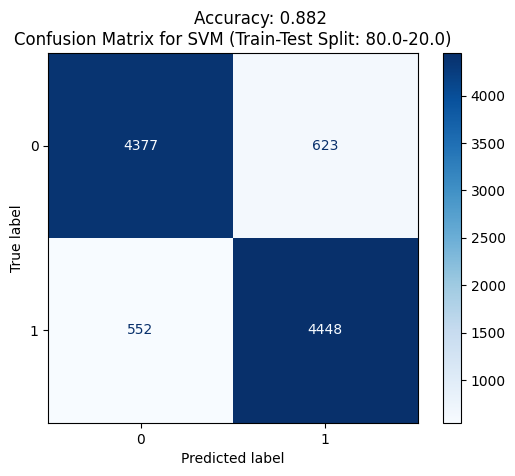

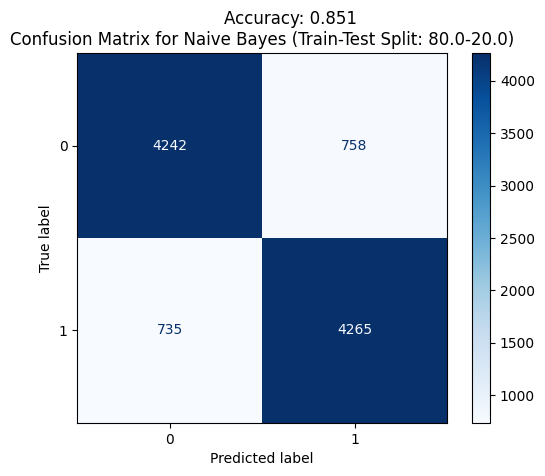

/tmp/ipykernel_16019/831665476.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, svm_metrics, nb_metrics], ignore_index=True)


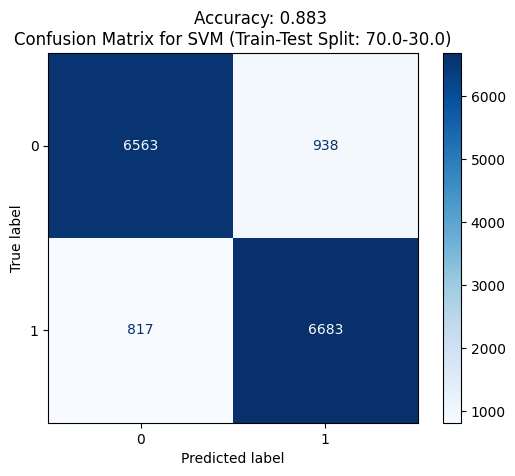

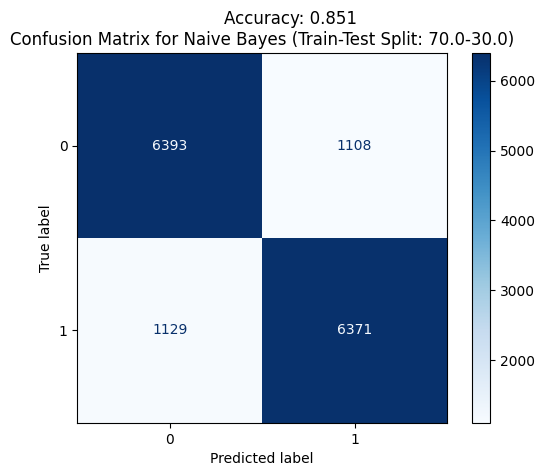

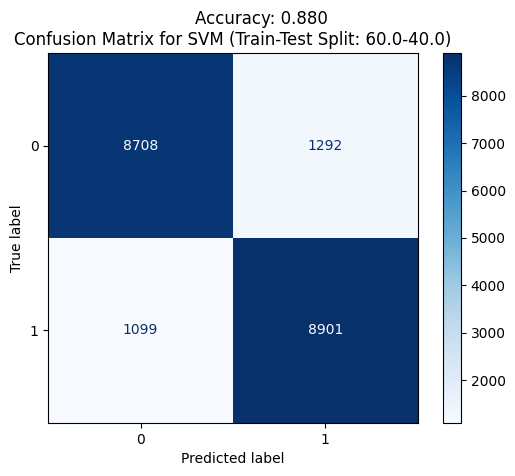

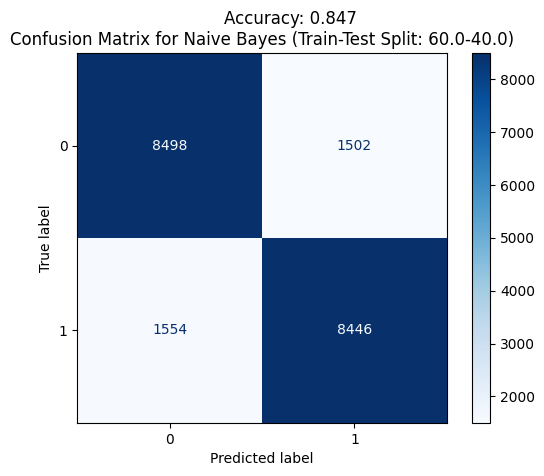

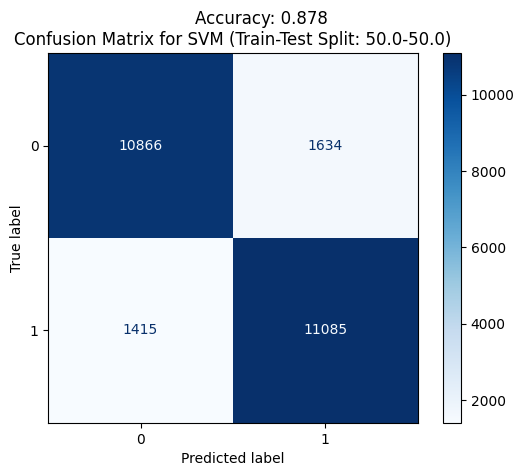

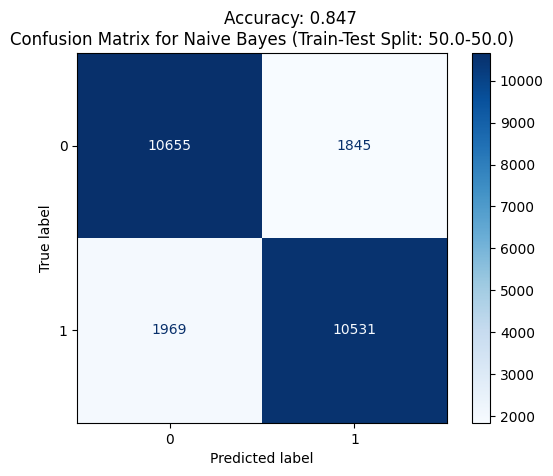

In [13]:
resultsRecall = pd.DataFrame(columns=['Split', 'Model','Accuracy',
                                'Class 0 Precision', 'Class 0 Recall', 'Class 0 F1 Score',
                                'Class 1 Precision', 'Class 1 Recall', 'Class 1 F1 Score'])
splits = [0.8,0.7,0.6,0.5]
for split in splits:
    # Step 1: Split the data
    X_train, X_test, y_train, y_test = joblib.load(f'../../data_splits/imdb/imdbdata_split_{split}.joblib')
    best_svm = joblib.load(f'../../models/imdb/svmModel_{split}.joblib')
    best_nb = joblib.load(f'../../models/imdb/nbModel_{split}.joblib')
    test(split,X_train, X_test, y_train, y_test,best_svm,best_nb)
    
    